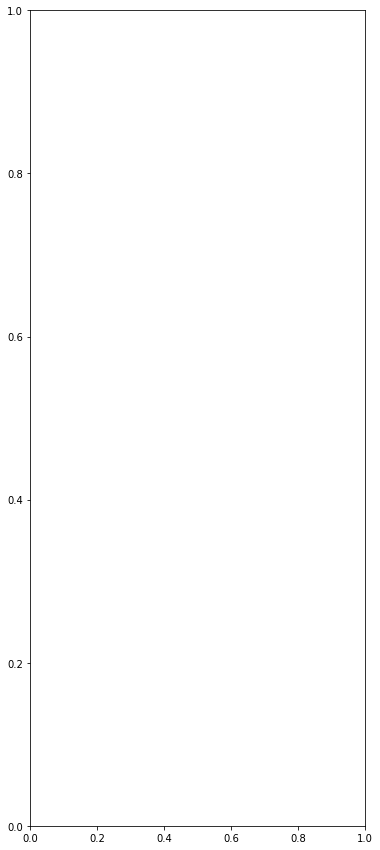

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout, Normalization
from keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from utils.functions import *
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("NUM GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

NUM GPUs Available:  1


In [3]:
from tensorflow.keras.applications import MobileNetV2
from keras.applications.resnet import preprocess_input

model = MobileNetV2(include_top=False, input_shape=(112, 112,3),
                 pooling="avg",weights=None)
model_name = "MobileNetV2"

In [4]:
train_path = "data/train"
test_path = "data/test"
labels = {"akiec":0, "bcc":1, "bkl":2, "df":3, "mel":4, "nv":5, "vasc":6}
classes = list(labels.keys())
size = (112,112)

In [5]:
model_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range = 40,
                                        width_shift_range = 0.2, height_shift_range = 0.2, rescale = 1./255,
                                        shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,
                                        validation_split=.1)

train_batches = model_generator.flow_from_directory(train_path,target_size=size,classes=classes,
                                                batch_size=100, shuffle=True, subset="training")
validation_batches = model_generator.flow_from_directory(train_path,size,classes=classes,
                                                batch_size=40, shuffle=True, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
    .flow_from_directory(test_path,size,classes=classes, batch_size=10, shuffle=False)

Found 7213 images belonging to 7 classes.
Found 799 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [6]:
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(2000, activation="relu")(flat1)
class2 = Dropout(rate=.5)(class1)
class3 = Dense(1000, activation="relu")(class2)
class4 = Dropout(rate=.3)(class3)
class5 = Dense(500, activation="relu")(class4)
# class6 = Dropout(rate=.2)(class5)
output = Dense(7, activation="softmax")(class5)
model = Model(inputs=model.inputs, outputs=output)

In [7]:
learning_rate = 0.06
optimizer = Adam(learning_rate)
loss = "categorical_crossentropy"
metrics = "accuracy"

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('deployment/models/'+model_name+'_training_{accuracy:.4f}_{val_accuracy:.4f}.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)
lrl = ReduceLROnPlateau(patience=10,verbose=1,monitor="loss")

In [ ]:
history = model.fit(train_batches, validation_data= validation_batches,
          epochs=500, shuffle=True, verbose=2, callbacks=[es,mc,lrl])

Epoch 1/500
73/73 - 55s - loss: 3150.6775 - accuracy: 0.6020 - val_loss: 5785.1606 - val_accuracy: 0.6708

Epoch 00001: val_accuracy improved from -inf to 0.67084, saving model to deployment/models\MobileNetV2_training_0.6020_0.6708.h5


C:\ProgramData\Anaconda3\envs\tensorflowRELOADED\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/500
73/73 - 47s - loss: 81.4787 - accuracy: 0.6621 - val_loss: 1.1459 - val_accuracy: 0.6708

Epoch 00002: val_accuracy did not improve from 0.67084
Epoch 3/500
73/73 - 48s - loss: 1.7307 - accuracy: 0.6684 - val_loss: 1.1296 - val_accuracy: 0.6708

Epoch 00003: val_accuracy did not improve from 0.67084
Epoch 4/500
73/73 - 47s - loss: 1.6129 - accuracy: 0.6687 - val_loss: 1.1277 - val_accuracy: 0.6708

Epoch 00004: val_accuracy did not improve from 0.67084
Epoch 5/500
73/73 - 45s - loss: 1.1381 - accuracy: 0.6691 - val_loss: 1.1281 - val_accuracy: 0.6708

Epoch 00005: val_accuracy did not improve from 0.67084
Epoch 6/500
73/73 - 45s - loss: 1.1349 - accuracy: 0.6692 - val_loss: 1.1282 - val_accuracy: 0.6708

Epoch 00006: val_accuracy did not improve from 0.67084
Epoch 7/500
73/73 - 45s - loss: 1.1335 - accuracy: 0.6693 - val_loss: 1.1278 - val_accuracy: 0.6708

Epoch 00007: val_accuracy did not improve from 0.67084
Epoch 8/500
73/73 - 45s - loss: 1.1634 - accuracy: 0.6692 - val

In [ ]:
y_pred_proba = model.predict(train_batches)
y_pred = np.argmax(y_pred_proba)

In [ ]:
best_model = keep_best_saved_h5("/deployment/models/",model_name,0.2)
model = load_model(f"deployment/models/{best_model}")

In [ ]:
print(y_pred_proba)
print(best_model)